In [186]:
from micrograd.engine import Value as v
import math
from math import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from graphviz import Digraph

In [244]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._op = _op
        self.label = label
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda: None
    def __repr__(self):
        return(f'Value(data) = {self.data}')
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other),'+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
       
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
            return self * other
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        return out

    def tanh(self):
        n = self.data
        t = ((math.exp(2*n)-1) / (math.exp(2*n)+1))
        out = Value(t, (self, ), 'tanh')
        def _backward(): 
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward(self):
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int and float for now"
        out = Value(self.data ** other, (self,), 'f**{other}')
        def _backward(self):
            self.grad = other * (self.data **(other -1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other **-1
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [257]:
a = Value(2, label = 'a')
b = Value(-3, label = 'b')
c = Value(10, label = 'c')
d = a * b; d.label = 'd'
e = c + d; e.label ='e'
f = Value(2, label = 'f')
L = e * f; L.label = 'L'

In [258]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr= {'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{%s | data %.4f |grad %.4f} ' % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


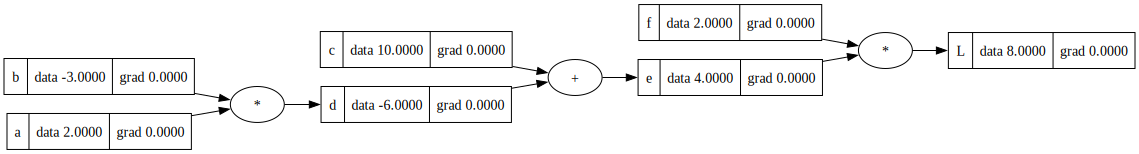

In [259]:
draw_dot(L)
#L.backward()

# BACK PROPAGATION

In [100]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(2.0, label = 'w2')
b = Value(6.7, label= 'b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

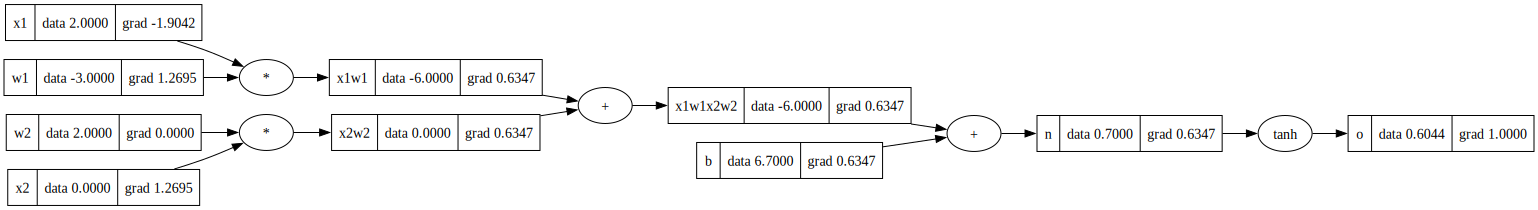

In [103]:
draw_dot(o)